In [40]:
import openai
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [32]:
# Using the function you provided
def load_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Load JSON data
input_file = "contract_case_summaries.json"
json_data = load_json_file(input_file)


In [49]:
# Function to create prompts from JSON data
def create_prompts_from_json(json_cases):
    prompts = []
    for case in json_cases:
        prompt = f"""You are a legal expert specializing in U.S. contract law. Based on the following case details, predict the court's decision and provide the legal reasoning.

---

**Case Title**: {case.get('case_title', 'N/A')}

**Jurisdiction**: {case.get('jurisdiction', 'N/A')}

### **Facts**

#### **Parties**
- **Plaintiff**: {case['facts']['parties'].get('plaintiff', 'N/A')}
- **Defendant**: {case['facts']['parties'].get('defendant', 'N/A')}

#### **Contract Details**
- **Type**: {case['facts']['contract_details'].get('type', 'N/A')}
- **Key Terms**:
"""
        # Add key terms
        key_terms = case['facts']['contract_details'].get('key_terms', {})
        for term, description in key_terms.items():
            prompt += f"  - **{term.replace('_', ' ').title()}**: {description}\n"

        # Add timeline of events
        prompt += "\n#### **Timeline of Events**\n"
        for event in case['facts'].get('timeline_of_events', []):
            prompt += f"- **{event.get('date', 'N/A')}**: {event.get('event', 'N/A')}\n"

        # Add legal issues
        prompt += "\n### **Legal Issues**\n\n"
        primary_issues = case['legal_issues'].get('primary_issues', [])
        if primary_issues:
            prompt += "#### **Primary Issue(s)**\n"
            for idx, issue in enumerate(primary_issues, 1):
                prompt += f"{idx}. {issue}\n"

        secondary_issues = case['legal_issues'].get('secondary_issues', [])
        if secondary_issues:
            prompt += "\n#### **Secondary Issue(s)**\n"
            for idx, issue in enumerate(secondary_issues, 1):
                prompt += f"{idx}. {issue}\n"

        prompt += "\n---\n"
        prompt += "Please provide:\n\n"
        prompt += "1. **Decision**: Should the court rule in favor of the plaintiff or the defendant?\n"
        prompt += "2. **Legal Reasoning**: Explain the reasoning behind the decision, citing relevant legal principles and statutes.\n"

        prompts.append({
            'case_title': case.get('case_title', 'N/A'),
            'prompt': prompt
        })
    return prompts

# Generate prompts
prompts_list = create_prompts_from_json(json_data)


{'case_title': 'Case Title 4',
 'prompt': "You are a legal expert specializing in U.S. contract law. Based on the following case details, predict the court's decision and provide the legal reasoning.\n\n---\n\n**Case Title**: Case Title 4\n\n**Jurisdiction**: United States District Court for California\n\n### **Facts**\n\n#### **Parties**\n- **Plaintiff**: Plaintiff Company 4, a tech startup.\n- **Defendant**: Defendant Agency 4, a marketing firm.\n\n#### **Contract Details**\n- **Type**: Service Agreement for Marketing Campaign\n- **Key Terms**:\n  - **Delivery Date**: December 5, 2022\n  - **Payment**: $30000 upon delivery of services\n  - **Performance Obligations**: Execution of a targeted advertising campaign for product 4.\n\n#### **Timeline of Events**\n- **July 5, 2022**: Contract signed.\n- **September 14, 2022**: Defendant requests delay; plaintiff refuses.\n- **December 5, 2022**: Defendant fails to deliver services.\n- **December 9, 2022**: Plaintiff files lawsuit.\n\n### *

In [56]:
import os
from openai import OpenAI

def get_llm_prediction(prompt):
    # Retrieve the API key from environment variables
    api_key = os.getenv('OPENAI_API_KEY')
    if not api_key:
        raise ValueError("API key not found. Please set the 'OPENAI_API_KEY' environment variable.")
    
    # Initialize the OpenAI client with your API key
    client = OpenAI(api_key=api_key)
    
    # Create a chat completion
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # Replace with your desired chat model
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=1024,
        temperature=0  # Deterministic output
    )
    
    # Return the generated text
    return response.choices[0].message.content.strip()


In [57]:
llm_predictions = []

for idx, item in enumerate(prompts_list):
    prompt = item['prompt']
    print(f"Processing case: {item['case_title']}")
    prediction = get_llm_prediction(prompt)
    llm_predictions.append({
        'case_title': item['case_title'],
        'prediction': prediction
    })

llm_predictions_df = pd.DataFrame(llm_predictions)
llm_predictions_df.to_csv('llm_predictions.csv', index=False)


Processing case: Case Title 4
Processing case: Case Title 5
Processing case: Case Title 6
Processing case: Case Title 7
Processing case: Case Title 8
Processing case: Case Title 9
Processing case: Case Title 10
Processing case: Case Title 11
Processing case: Case Title 12
Processing case: Case Title 13
Processing case: Case Title 14
Processing case: Case Title 15
Processing case: Case Title 16
Processing case: Case Title 17
Processing case: Case Title 18
Processing case: Case Title 19
Processing case: Case Title 20
Processing case: Case Title 21
Processing case: Case Title 22
Processing case: Case Title 23
Processing case: Case Title 24
Processing case: Case Title 25
Processing case: Case Title 26
Processing case: Case Title 27
Processing case: Case Title 28
Processing case: Case Title 29
Processing case: Case Title 30
Processing case: Case Title 31
Processing case: Case Title 32
Processing case: Case Title 33
Processing case: Case Title 34
Processing case: Case Title 35
Processing cas

In [58]:
def parse_prediction(prediction_text):
    # Initialize variables
    decision = None
    legal_reasoning = ""
    lines = prediction_text.strip().split('\n')

    # Parse the prediction text
    for line in lines:
        if "**Decision**" in line or "Decision:" in line:
            decision_line = line
            decision = line.split("Decision:")[-1].strip().strip('*').strip()
        elif "**Legal Reasoning**" in line or "Legal Reasoning:" in line:
            # Start collecting legal reasoning
            reasoning_index = lines.index(line) + 1
            legal_reasoning = '\n'.join(lines[reasoning_index:]).strip()
            break

    return decision, legal_reasoning


In [59]:
parsed_predictions = []

for prediction_item in llm_predictions:
    decision, reasoning = parse_prediction(prediction_item['prediction'])
    parsed_predictions.append({
        'case_title': prediction_item['case_title'],
        'decision': decision,
        'legal_reasoning': reasoning
    })


In [60]:
# Extract ground truth decisions
ground_truth_decisions = {}
for case in json_data:
    case_title = case.get('case_title', 'N/A')
    decision = case['outcome'].get('decision', '')
    ground_truth_decisions[case_title] = decision


In [61]:
def normalize_decision(decision_text):
    if decision_text is None:
        return 'Unknown'
    decision_text = decision_text.lower()
    if 'plaintiff' in decision_text:
        return 'Plaintiff'
    elif 'defendant' in decision_text:
        return 'Defendant'
    else:
        return 'Unknown'


In [62]:
evaluation_data = []

for prediction in parsed_predictions:
    case_title = prediction['case_title']
    predicted_decision = normalize_decision(prediction['decision'])
    actual_decision = normalize_decision(ground_truth_decisions.get(case_title, 'Unknown'))
    is_correct = predicted_decision == actual_decision
    evaluation_data.append({
        'case_title': case_title,
        'predicted_decision': predicted_decision,
        'actual_decision': actual_decision,
        'is_correct': is_correct,
        'legal_reasoning': prediction['legal_reasoning']
    })

evaluation_df = pd.DataFrame(evaluation_data)


In [67]:
accuracy = evaluation_df['is_correct'].mean()
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")


Prediction Accuracy: 52.58%


In [68]:
from sklearn.metrics import confusion_matrix

labels = ['Plaintiff', 'Defendant', 'Unknown']
cm = confusion_matrix(evaluation_df['actual_decision'], evaluation_df['predicted_decision'], labels=labels)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)


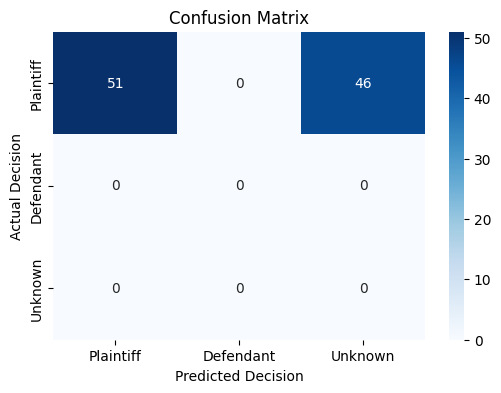

In [69]:
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Decision')
plt.xlabel('Predicted Decision')
plt.title('Confusion Matrix')
plt.show()


In [70]:
total_cases = len(evaluation_df)
correct_cases = evaluation_df['is_correct'].sum()
incorrect_cases = total_cases - correct_cases

print(f"Total Cases Evaluated: {total_cases}")
print(f"Correct Predictions: {correct_cases}")
print(f"Incorrect Predictions: {incorrect_cases}")


Total Cases Evaluated: 97
Correct Predictions: 51
Incorrect Predictions: 46


In [71]:
misclassified = evaluation_df[~evaluation_df['is_correct']]

for idx, row in misclassified.iterrows():
    print(f"\nCase Title: {row['case_title']}")
    print(f"Predicted Decision: {row['predicted_decision']}")
    print(f"Actual Decision: {row['actual_decision']}")
    print("LLM Legal Reasoning:")
    print(row['legal_reasoning'])



Case Title: Case Title 4
Predicted Decision: Unknown
Actual Decision: Plaintiff
LLM Legal Reasoning:
1. **Breach of Contract**: The primary issue in this case is whether Defendant Agency 4 breached the service agreement by failing to deliver the marketing campaign by the specified delivery date of December 5, 2022. Under U.S. contract law, a breach occurs when one party fails to perform their obligations under the contract without a valid legal excuse. In this case, the defendant did not deliver the services by the agreed-upon date, which constitutes a clear breach of the contract.

2. **Defendant's Request for Delay**: The defendant's request for a delay on September 14, 2022, was refused by the plaintiff. This refusal indicates that the plaintiff was not willing to modify the terms of the contract, and the defendant's failure to deliver on the original timeline is not excused by the request for a delay. The defendant had a contractual obligation to perform by the specified date, and

In [72]:
evaluation_df.to_csv('llm_evaluation_results.csv', index=False)
